
ReLU defense
==============================

**Author:** https://github.com/aliborji/ReLU_defense.git



In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

from torch.utils.data import DataLoader, TensorDataset

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks
from torchattacks import PGD

In [3]:
cuda = torch.cuda.is_available()

In [4]:
cuda

False

In [5]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [6]:
def test_BPDA( model, model_orig, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
#         loss = F.nll_loss(output, target)
        loss = F.cross_entropy(output, target)        

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
#         output = model(perturbed_data)
        output = model_orig(perturbed_data)        

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [7]:
def srelu(input, slope):
    return slope * F.relu(input)

class SReLU(nn.Module):
    def __init__(self):
        super().__init__() # init the base class

    def forward(self, input, slope):
        return srelu(input, slope) # simply apply already implemented SiLU

In [8]:
# local machine
pretrained_model = './models/cifar_net.pth' #pretrained_model = "lenet_mnist_model.pth"
cuda=False

In [21]:
transform = transforms.Compose( 
    [transforms.ToTensor()]) 


cifar10_train  = dsets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)


train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=100,
                                        shuffle=True, num_workers=1)



cifar10_test  = dsets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=100,
                                        shuffle=False, num_workers=1)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_cls = len(classes)
p = next(iter(train_loader))[0].shape[-1]

Files already downloaded and verified
Files already downloaded and verified


RuntimeError: DataLoader worker (pid 76189) is killed by signal: Unknown signal: 0. 

In [10]:
a, b = next(iter(test_loader))

In [11]:
a.max()

tensor(1.)

# training a model first

In [13]:
class Net(nn.Module):
    def __init__(self, slope):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.slope = slope

    def forward(self, x):
        x = self.pool(srelu(self.conv1(x), self.slope))
        x = self.pool(srelu(self.conv2(x), self.slope))
        x = x.view(-1, 16 * 5 * 5)
        x = srelu(self.fc1(x), self.slope)
        x = srelu(self.fc2(x), self.slope)
        x = self.fc3(x)
        return x #F.log_softmax(x, dim=1)

use_cuda = False
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# # Initialize the network
model = Net(1).to(device)

# # Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# # Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()
if cuda:
    model.cuda() # CUDA!
optimizer = optim.Adam(model.parameters(), lr=1e-3)

CUDA Available:  False


In [14]:
model = Net(1).to(device)  # training with slope 1 for now

In [15]:
from torchsummary import summary
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# vgg = models.vgg16().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


# Model with increased slope

In [16]:
pretrained_model = './models/cifar_net.pth' 

In [17]:
sl =  100
model = Net(sl).to(device)
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
model.eval()


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Accuracy: tensor(57.3900, dtype=torch.float64)


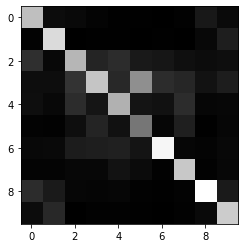

In [18]:
model.eval()

hit = 0
total = 0
preds = []
targets = []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
#         data, target = data.cuda(), target.cuda()
        pred = model(data).max(1)[1]
        preds.extend(pred.cpu().tolist())
        targets.extend(target.cpu().tolist())
        hit += pred.eq(target).cpu().sum()
        total += len(target)
accuracy = hit.type(dtype=torch.float64)/total

print('Accuracy:', accuracy*100)


import sklearn
from sklearn import metrics
# sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())
aa = sklearn.metrics.confusion_matrix(preds, targets)
plt.imshow(aa, cmap = 'gray')
# plt.title('8 -> 9')

# Train a new model

### 1- Make a new network and train it with the logits of the first network
### 2- Make an adversarial for the 2nd network and apply it to the 1st one

In [23]:
model_new = Net(1).to(device) 

In [24]:
EPOCHS = 10
losses = []

optimizer = optim.Adadelta(model_new.parameters())

loss_fn = nn.BCELoss()
softmax = nn.Softmax()


model_new.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.to(device)        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model_new(data) # y_pred is the logits now

        # Predict of the original model
#         import pdb; pdb.set_trace()
        y_model_orig = model(data) # this is the logit
        
#         loss = loss_fn(y_pred, y_model_orig)        
        loss = loss_fn(softmax(y_pred), softmax(y_model_orig.detach()))        
        
        
        # Calculate loss
#         loss = F.cross_entropy(y_pred, target)
#         loss = F.cross_entropy(y_pred, y_model_orig)
#         loss = F.nll_loss(y_pred, y_model_orig)
    

        losses.append(loss.cpu().data)
#         losses.append(loss.cpu().data[0])        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch+1,
                  EPOCHS,
                  batch_idx * len(data),
                  len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), 
                  loss.cpu().data), 
                  end='')
    # Eval
    model_new.eval()
    hit = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
#             if cuda:
#                 data, target = data.cuda(), target.cuda()
                pred = model_new(data).max(1)[1]
                hit += pred.eq(target).cpu().sum()
                total += len(target)
    accuracy = hit.type(dtype=torch.float64)/total
    
    # save best
    # if accuracy > best_acc:
    #     best_acc = accuracy
    #     torch.save({'epoch': epoch,
    #               'model': model.state_dict(),
    #               'optimizer': optimizer.state_dict()
    #              }, '{}/models/epoch_{}.pth'.format(save_path, epoch))
    #     print('\r Best model saved.\r')
      
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data,
        accuracy*100,
        end=''))

Traceback (most recent call last):


RuntimeError: DataLoader worker (pid 76201) is killed by signal: Unknown signal: 0. 

  File "/Users/ali/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/ali/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/ali/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/ali/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/ali/anaconda3/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/Users/ali/anaconda3/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/Users/ali/anaconda3/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


In [134]:
accuracy

tensor(0.4972, dtype=torch.float64)

# Now the new model is cooked and ready; Lets see if adversarial examples for the new model still fool the original model

In [112]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

# Set the model in evaluation mode. In this case this is for the Dropout layers
model_new.eval()

# Run test for each epsilon
accuracies = []
examples = []

for eps in epsilons:
#     acc, ex = test_BPDA(model_new, model, device, test_loader, eps)
    acc, ex = test_BPDA(model, model, device, test_loader, eps)
    
    accuracies.append(acc)
    examples.append(ex)



Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


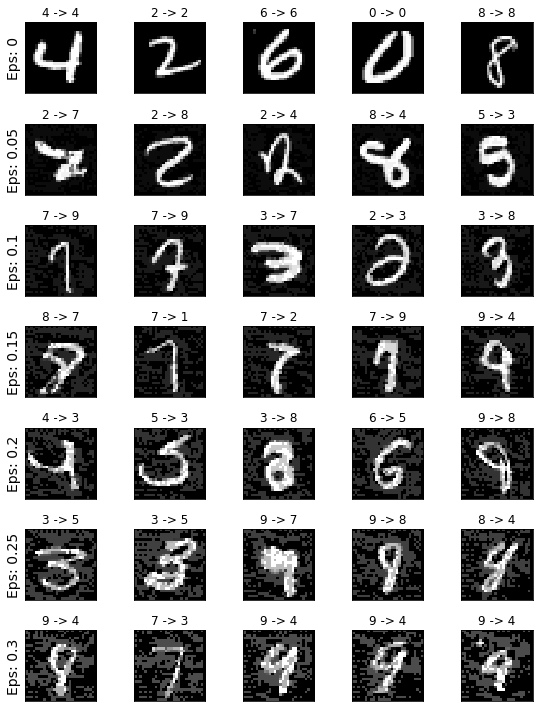

In [67]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [36]:
plt.figure(figsize=(5,5))
symbs = ['*-', 'o-', 's-', 'd-', '+-', 'x-', '^-']
for idx, sl in enumerate(all_accuracies):
    plt.plot(epsilons, sl, symbs[idx])
    
#     plt.plot(epsilons, np.array(all_accuracies).T, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(slopes)
plt.show()

NameError: name 'all_accuracies' is not defined

<Figure size 360x360 with 0 Axes>

In [114]:
# results 
BPDA= np.array([[0.974, 0.9647, 0.9402, 0.8928, 0.8054, 0.6668, 0.476],
[0.9745, 0.9671, 0.9565, 0.9345, 0.8943, 0.8226, 0.7054],  # 2 
[0.9757, 0.9675, 0.9547, 0.9301, 0.8865, 0.8067, 0.6804],  # sl 5
[0.9742, 0.9679, 0.9556, 0.9341, 0.8967, 0.8349, 0.7363],  # sl 10
[0.9743, 0.9653, 0.9509, 0.9221, 0.8674, 0.7809, 0.6449]])  # sl 100

sl1_sl1= [0.981, 0.9426, 0.851, 0.6826, 0.4301, 0.2082, 0.0869]

# BPDA = np.array(BPDA)

In [89]:
import matplotlib.pyplot as plt

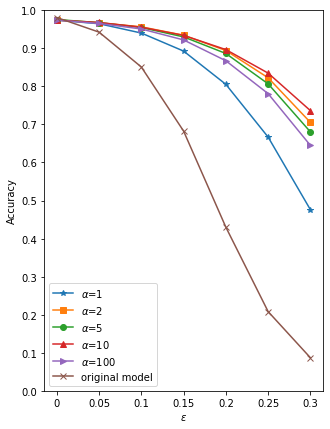

In [121]:
# plt.plot(BPDA.T)
fig=plt.figure(figsize=(5,7))
symbs = ['*-', 's-', 'o-', '^-', '>-', 'x-', '<-']
for idx, x in enumerate(BPDA):
    plt.plot(x, symbs[idx])


plt.plot(sl1_sl1, symbs[idx+1])
    
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, len(epsilons)), epsilons)
plt.ylim([0,1])
plt.legend([r'$\alpha$=1', r'$\alpha$=2', r'$\alpha$=5', r'$\alpha$=10', r'$\alpha$=100', r'original model'])
plt.xlabel(r'$\epsilon$')
plt.ylabel("Accuracy")

plt.show()

In [80]:
BPDA.shape

(35,)

In [ ]:
B